# Visualize CDX2 expression in gut and liver

In [3]:
import anndata
import numpy as np
import pandas as pd
import os, sys
import scanpy as sc
import plotnine as p9

## Load pre-filtering expression matrices

In [2]:
save_dir="/gstore/data/resbioai/grelu/decima/20240823/"
sci_file = os.path.join(save_dir, "processed_pseudobulks/scimilarity_processed.h5ad")
ci_file = os.path.join(save_dir, "processed_pseudobulks/combined_inner.h5ad")
matrix_file = os.path.join(save_dir, "data.h5ad")

In [4]:
sci = anndata.read_h5ad(sci_file)
ad = anndata.read_h5ad(matrix_file)
ci = anndata.read_h5ad(ci_file)

/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Get CDX2 expression

In [5]:
sci.obs['CDX2'] = np.array(sci[:, 'CDX2'].X).squeeze()

In [6]:
sci = sci[:, ci.var.gene_name.tolist()]
del ci

In [7]:
sci.var['frac_nan'] = np.isnan(sci.X).mean(0) 
sci = sci[:, sci.var.frac_nan < .33]

/tmp/ipykernel_627874/272250441.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  sci.var['frac_nan'] = np.isnan(sci.X).mean(0)


## Aggregate the pseudobulks from scimilarity

In [13]:
by_cols=['cell_type', 'tissue', 'organ', 'disease', 'study']
sum_cols=['n_cells', 'CDX2']

# Get column names
obs_cols = by_cols+sum_cols
gene_names = sci.var_names.tolist()

# Format obs
print("Creating new obs matrix")
obs = sci.obs[obs_cols].copy()
for col in by_cols:
    obs[col] = obs[col].astype(str)
for col in sum_cols:
    obs[col] = obs[col].astype(float)

Creating new obs matrix


In [18]:
# Create X
X = pd.DataFrame(sci.X, index=obs.index.tolist(), columns=gene_names)
X = pd.concat([obs,X], axis=1)

# Aggregate X
print("Aggregating")
X = X.groupby(by_cols).sum().reset_index()

# Split off the obs again
obs = X[obs_cols]
obs.index = [f'agg_{i}' for i in range(len(obs))]
X = X[gene_names]

# Create new anndata
print("Creating new anndata")
new_sc = anndata.AnnData(X=np.array(X), obs=obs, var=sci.var.copy())

Aggregating
Creating new anndata


## Filter the pseudobulks

In [19]:
new_sc.obs['total_counts'] = new_sc.X.sum(1)
new_sc.obs['n_genes'] = np.sum(new_sc.X > 0, axis=1)

In [20]:
drop = (new_sc.obs.n_cells < 50) & (new_sc.obs.n_genes < 7670) & (new_sc.obs.total_counts < 76505)
new_sc = new_sc[~drop]

## Normalize

In [22]:
sc.pp.normalize_total(new_sc, target_sum=1e6) 

/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
new_sc.obs['CDX2'] = new_sc.obs['CDX2']*1e6/new_sc.obs['total_counts']

In [24]:
sc.pp.log1p(new_sc) 

In [25]:
new_sc.obs['CDX2'] = np.log1p(new_sc.obs['CDX2'])

## Visualize

In [29]:
new_sc = new_sc[new_sc.obs.organ.isin(['gut', 'liver'])]

In [32]:
new_sc.obs['label']= "Other"

In [34]:
new_sc.obs.loc[new_sc.obs.organ=='gut', 'label'] = 'Other gut'
new_sc.obs.loc[new_sc.obs.organ=='liver', 'label'] = 'Other liver'
new_sc.obs.loc[new_sc.obs.cell_type=='enterocyte', 'label'] = 'Enterocyte'
new_sc.obs.loc[new_sc.obs.cell_type=='hepatocyte', 'label'] = 'Hepatocyte'

In [35]:
new_sc.obs['label'] = pd.Categorical(new_sc.obs['label'], categories=['Enterocyte', 'Other gut', 'Hepatocyte', 'Other liver'])

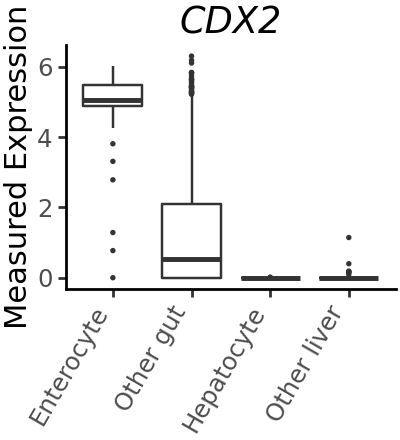

In [50]:
(
    p9.ggplot(new_sc.obs, p9.aes(x='label', y="CDX2"))
    + p9.geom_boxplot(outlier_size=0.1) + p9.theme_classic() 
    + p9.theme(figure_size=(2, 2.2))
    + p9.ylab("Measured Expression")
    + p9.ggtitle('CDX2')
    + p9.theme(plot_title = p9.element_text(face = "italic"))
    + p9.theme(axis_title_x = p9.element_blank())
    + p9.theme(axis_text_x=p9.element_text(rotation=60, hjust=1))
)